### TP : Classification de texte avec un RNN

Dans ce TP, nous allons construire un modèle de réseau de neurones récurrent (RNN) pour effectuer une analyse de sentiments sur le jeu de données IMDB. Nous suivrons les étapes suivantes :

1. Préparation de l'environnement et des données.
2. Création de l'encodeur de texte.
3. Construction et entraînement du modèle RNN.
4. Évaluation et visualisation des performances.

### Étape 1 : Préparation de l'environnement et des données

Importez les bibliothèques nécessaires (`numpy`, `tensorflow`, `tensorflow_datasets`, `matplotlib`).

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

Chargez le jeu de données IMDB via `tensorflow_datasets` et séparez-le en ensembles d'entraînement et de test.

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Afficher un échantillon de données

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


La cellule suivante prépare les ensembles de données en les mélangeant, les groupant en batchs, et en activant la prélecture pour optimiser les performances.

Pourquoi utiliser .prefetch ? <br>
Lors de l'entraînement d'un modèle, les étapes de traitement des données (chargement, déchiffrement, augmentation, etc.) peuvent devenir un goulot d'étranglement si elles prennent plus de temps que l'entraînement lui-même.<br>
Sans prefetch : Le modèle attend que les données soient préparées avant de continuer son entraînement.<br>
Avec prefetch : Les données pour la prochaine itération sont préparées en parallèle pendant que le modèle entraîne l'itération en cours.

Que fait tf.data.AUTOTUNE ?<br>
Le paramètre AUTOTUNE permet à TensorFlow de déterminer automatiquement le nombre optimal de lots de données à précharger dans le buffer, en fonction des ressources disponibles (CPU, GPU, mémoire).

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Exemple d'affichage
for example, label in train_dataset.take(1):
    print('Exemples de textes :', example.numpy()[:3])
    print('Labels correspondants :', label.numpy()[:3])

Exemples de textes : [b"The animation looks like it was done in 30 seconds, and looks more like caricatures rather than characters. I've been a fan of Scooby Doo ever since the series premiered in 1969. I didn't think much of the Scooby Doo animated movies, (I'm talking about the TV Series, not the full length movies.), but some of them were pretty cool, and I like most people found Scrappy Doo to be an irritant, but this series is pure garbage. As soon as I saw the animation, and heard the characters, (and I use that term loosely) speak, I cringed. Also, Mystery Inc., was a team, and without the entire crew to compliment each other, it just seems like opening up a box of chocolates to find someone has already ate the best ones, and the only thing left are the ones nobody wants. What's New Scooby Doo was better than this. If you're going to have a Scooby Doo TV series, include the elements that made the series endure so long. The entire cast of characters, and quality animation. They n

### Étape 2 : Création de l'encodeur de texte

Utilisez `TextVectorization` de Keras pour encoder les textes en indices numériques. Adaptez l'encodeur aux données d'entraînement pour construire le vocabulaire. Note : dans TensorFlow Keras, fit est réservé à l'entraînement des modèles. Son pendant est adapt lorsqu'il concerne des couches qui "s'ajustent" aux données (prétraitement).


In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, _: text))

Affichez les 20 premiers mots du vocabulaire pour validation.

In [7]:
# Affichage des 20 premiers mots du vocabulaire
vocab = np.array(encoder.get_vocabulary())
print("Premiers mots du vocabulaire :", vocab[:20])

Premiers mots du vocabulaire : ['' '[UNK]' 'the' 'and' 'a' 'of' 'to' 'is' 'in' 'it' 'i' 'this' 'that'
 'br' 'was' 'as' 'for' 'with' 'movie' 'but']


### Étape 3 : Construction du modèle RNN

Construisez un modèle séquentiel Keras composé des couches suivantes :
  1. L'encodeur de texte.
  2. Une couche d'embedding avec 64 dimensions.
  3. Une couche bidirectionnelle avec un LSTM de 64 unités.
  4. Une couche Dense avec 64 unités et activation ReLU.
  5. Une couche Dense avec une sortie unique (classification binaire).

In [19]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(vocab),
        output_dim=64,
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1),
])

Compilez le modèle avec une perte de votre choix (bien choisie !), l'optimiseur `Adam` et la métrique `accuracy`.

In [20]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"],
)

Imaginons que nous n'ayons pas renseigné d'argument activation dans la dernière couche dense. Quel va être l'impact, s'il y en a un, par rapport au scénario où nous aurions renseigné "sigmoid" ? Proposer une règle pour convertir les outputs en prédictions binaires. 

### Étape 4 : Entraînement du modèle

Entraînez le modèle sur le jeu d'entraînement pour 10 epochs.

In [21]:
history = model.fit(
    train_dataset,
    epochs=1,
    validation_data=test_dataset,
    )

391/391 [==============================] - 1486s 4s/step - loss: 0.5361 - accuracy: 0.7074 - val_loss: 0.4419 - val_accuracy: 0.8120


### Etape 5 : Evaluation du modèle et affichage des résultats

Évaluez le modèle sur le jeu de test.
Affichez les courbes d'entraînement (précision et perte).

In [23]:
test_loss, test_acc = model.evaluate(test_dataset)
print(test_loss)
print(test_acc)

 58/391 [===>..........................] - ETA: 1:30 - loss: 0.4408 - accuracy: 0.8155

KeyboardInterrupt: 

In [26]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("epoch")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

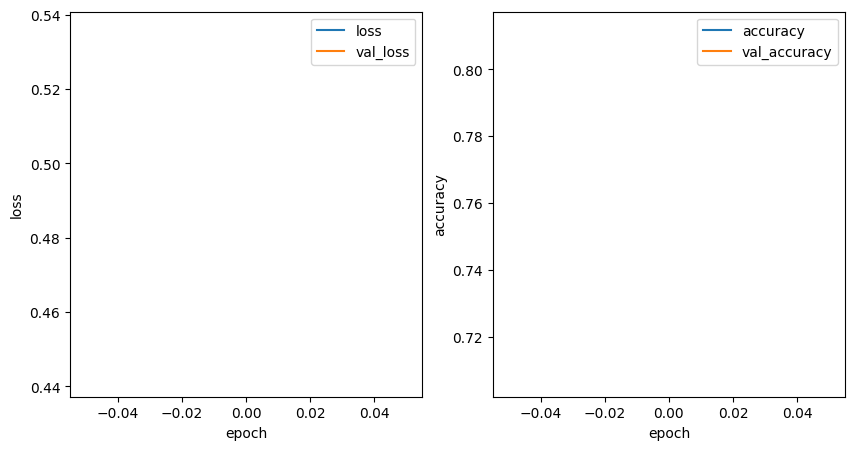

In [27]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, "loss")
plt.subplot(1, 2, 2)
plot_graphs(history, "accuracy")

### Étape 6 : Prédiction sur de nouveaux textes

Effectuez une prédiction sur un texte d'exemple. Ajoutez un second texte rempli de padding pour vérifier ses effets sur les prédictions.

In [33]:
sample_text = """It was a great movie. Beautiful landscapes and disgusting monsters (I love them).
               100% recommended"""
padding = " the" * 2000

print(model.predict(np.array([sample_text])))
print(model.predict(np.array([sample_text + padding])))


1/1 [==============================] - 0s 31ms/step
[[1.5582693]]
1/1 [==============================] - 0s 95ms/step
[[2.2787912]]


### Étape 7 : Ajouter une couche LSTM supplémentaire

Ajoutez une seconde couche bidirectionnelle LSTM (avec `return_sequences=True` sur la première). Réentraînez le modèle et observez les performances.

**A noter :** La sortie de la première couche LSTM est une séquence qui peut être traitée par la seconde couche.

In [35]:
model2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(vocab),
        output_dim=64,
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer="adam",
    metrics=["accuracy"],
)

history = model.fit(
    train_dataset,
    epochs=1,
    validation_data=test_dataset,
    )

test_loss, test_acc = model.evaluate(test_dataset)
print(test_loss)
print(test_acc)

391/391 [==============================] - 129s 329ms/step - loss: 0.5476 - accuracy: 0.7434
0.5476042628288269
0.7433599829673767
